This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
!pip uninstall lightgbm -y
!pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    country_num = 50

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 22.6 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
countries = train['country'].value_counts()
major_countries = countries[countries > CFG.country_num].index
major_countries

Index(['US', 'TR', 'ID', 'JP', 'TH', 'RU', 'BR', 'MY', 'BE', 'GB',
       ...
       'KG', 'BS', 'BB', 'IQ', 'TZ', 'NP', 'AW', 'AL', 'MU', 'VI'],
      dtype='object', length=123)

In [ ]:
mean_latlon = train[train['country'].isin(major_countries)].groupby('country')[['latitude', 'longitude']].mean().apply(lambda x: tuple(x), axis = 1).to_dict()
mean_latlon

{'AE': (25.031196156825867, 55.125843416026626),
 'AL': (41.16438043034689, 19.412328749941274),
 'AM': (40.226330254579786, 44.639090877452354),
 'AR': (-34.3017973185889, -59.675176940818325),
 'AT': (47.82784149912836, 14.668674401181589),
 'AU': (-33.60605387334255, 145.81505022396252),
 'AW': (12.538799105310463, -70.0247308418892),
 'AZ': (40.3754732198509, 49.74492239537704),
 'BA': (43.94847201899628, 18.204256543029196),
 'BB': (13.108549846295455, -59.59389100581457),
 'BD': (23.832095040888664, 89.78014903512299),
 'BE': (50.98628567649715, 4.058717644388699),
 'BG': (42.641392575674466, 24.688713330227394),
 'BH': (26.24331108929355, 50.43609293011559),
 'BN': (4.862897689074465, 114.81284056079086),
 'BO': (-17.41681635627208, -65.60334597395833),
 'BR': (-17.988610123699, -45.85137266040645),
 'BS': (25.231983080132643, -77.37871937281074),
 'BY': (53.76383874243366, 27.642714473147585),
 'CA': (46.58385749692528, -90.61994532648563),
 'CH': (46.95307870414659, 7.95513134

In [ ]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def correct_country(latlon):
    min_distance = float('inf')
    min_country = None
    for country in major_countries:
        distance = haversine(latlon, mean_latlon[country])
        if distance < min_distance:
            min_distance = distance
            min_country = country
    return min_country
train['new_country'] = train[['latitude', 'longitude']].apply(correct_country, axis = 1)
test['new_country'] = test[['latitude', 'longitude']].apply(correct_country, axis = 1)
print('Concordance rate: ' + str((train['country'] == train['new_country']).mean()))
train.head()

Concordance rate: 0.7304752672082837


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,new_country
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,BE
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,BR
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,TH
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,TR
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,ES


# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("new_country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df[f"d_near_{i}"] = dists[:, i]
            country_df[f"near_target_{i}"] = targets[nears[:, i]]
            for c in columns:
                country_df[f"near_{c}_{i}"] = country_df[c].values[nears[:, i]]

        for i in range(min(len(country_df), CFG.n_neighbors), CFG.n_neighbors):
            country_df[f"d_near_{i}"] = np.nan
            country_df[f"near_target_{i}"] = np.nan
            for c in columns:
                country_df[f"near_{c}_{i}"] = np.nan

        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_9,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_new_country_9,near_url_9,near_phone_9,near_categories_9
0,E_0013149ad8ed18,جامع الكرامة,24.362293,54.62793,nan,shakhbout,nan,nan,AE,nan,...,E_8bfba70b04b72f,bawabat al sharq mall / بوابة الشرق مول,nan,nan,abu dhabi,nan,ae,http://www.bawabatalsharqmall.ae,+97125031400,shopping malls


# Create Target

In [ ]:
print(CFG.target)

point_of_interest


In [ ]:
for i in range(CFG.n_neighbors):
    train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_new_country_9,near_url_9,near_phone_9,near_categories_9,target
0,E_0013149ad8ed18,جامع الكرامة,24.362293,54.627930,nan,shakhbout,nan,nan,AE,nan,...,bawabat al sharq mall / بوابة الشرق مول,nan,nan,abu dhabi,nan,ae,http://www.bawabatalsharqmall.ae,+97125031400,shopping malls,1.0
1,E_002e4c4793fbc7,s.p. warehousing,24.976119,55.189455,"plot no. 597-900, dubai investments park second",dubai,nan,nan,AE,nan,...,eclipse staging services llc,dubai investment park,dubai,nan,nan,ae,nan,043405474,event spaces,1.0
2,E_0031c764c706c6,bowling marina mall,24.473879,54.350251,nan,nan,nan,nan,AE,nan,...,noodle hut,khalidiyah mall,abu dhabi,abu dhabi,nan,ae,nan,nan,chinese restaurants,0.0
3,E_0069f71ef3f0e7,costa coffee,25.779779,55.940277,al qawasim corniche,ras al-khaimah,ra’s al khaymah,nan,AE,http://costacoffee.ae,...,جاليتوز galiti's,النعيم مول,رأس الخيمة,nan,nan,ae,nan,nan,african restaurants,0.0
4,E_0076e00a9cf084,sega republic,25.197408,55.278418,emaar blvd,downtown dubai,dubai,nan,AE,http://www.segarepublic.com,...,canon,the dubai mall,downtown,dubai,nan,ae,nan,+97143399171,camera stores,0.0


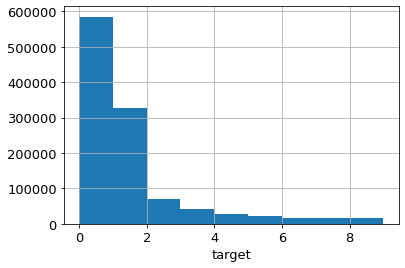

In [ ]:
plt.hist(train["target"], bins=sorted(train["target"].unique()))
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(input_df: pd.DataFrame):
    scores = []
    precisions = []
    recalls = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
scores = []

train["matches"] = ""
for i in tqdm(range(CFG.n_neighbors)):
    idx = train[CFG.target]==train[f"near_target_{i}"]
    train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]

    score, precision, recall = get_score(train)
    scores.append(score)
train["mathces"] = None

  0%|          | 0/10 [00:00<?, ?it/s]

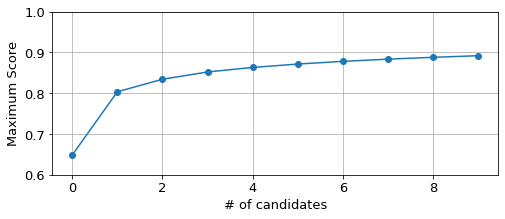

In [ ]:
plt.subplots(figsize=(8, 3), facecolor="white")
plt.plot(range(CFG.n_neighbors), scores, marker="o")
plt.grid()
plt.xlabel("# of candidates")
plt.ylabel("Maximum Score")
plt.ylim([0.6, 1.0])
plt.show()

In [ ]:
max(scores)

0.8920795134959725

In [ ]:
scores = []

train["matches"] = train["id"]
score, precision, recall = get_score(train)
scores.append(score)
for i in tqdm(range(1, CFG.n_neighbors)):
    idx = train["target"] == i
    train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]

    score, precision, recall = get_score(train)
    scores.append(score)
train["mathces"] = None

  0%|          | 0/9 [00:00<?, ?it/s]

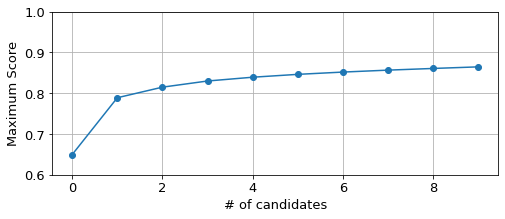

In [ ]:
plt.subplots(figsize=(8, 3), facecolor="white")
plt.plot(range(CFG.n_neighbors), scores, marker="o")
plt.grid()
plt.xlabel("# of candidates")
plt.ylabel("Maximum Score")
plt.ylim([0.6, 1.0])
plt.show()

In [ ]:
max(scores)

0.8647220884387373

In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 26.4 MB/s 
     |████████████████████████████████| 1.8 MB 71.3 MB/s 
     |████████████████████████████████| 103 kB 79.4 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']

    for i in tqdm(range(CFG.n_neighbors)):
        for c in columns:
            geshs = []
            levens = []
            jaros = []
            lcss = []
            for str1, str2 in df[[f"near_{c}_0", f"near_{c}_{i}"]].values.astype(str):
                if str1==str1 and str2==str2:
                    geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                    levens.append(Levenshtein.distance(str1, str2))
                    jaros.append(Levenshtein.jaro_winkler(str1, str2))
                    lcss.append(LCS(str(str1), str(str2)))
                else:
                    geshs.append(-1)
                    levens.append(-1)
                    jaros.append(-1)
            df[f"near_{c}_{i}_gesh"] = geshs
            df[f"near_{c}_{i}_leven"] = levens
            df[f"near_{c}_{i}_jaro"] = jaros
            df[f"near_{c}_{i}_lcs"] = lcss
            
            if not c in ['new_country', "phone", "zip"]:
                df[f"near_{c}_{i}_len"] = df[f"near_{c}_{i}"].astype(str).map(len)
                df[f"near_{c}_{i}_nleven"] = df[f"near_{c}_{i}_leven"] / df[[f"near_{c}_{i}_len", f"near_{c}_0_len"]].max(axis=1)
                df[f"near_{c}_{i}_nlcsi"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_{i}_len"]
                df[f"near_{c}_{i}_nlcs0"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_0_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('new_country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
(train['target'] == 0).sum() / len(train)

0.5132488944619481

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_9_jaro,near_phone_9_lcs,near_categories_9_gesh,near_categories_9_leven,near_categories_9_jaro,near_categories_9_lcs,near_categories_9_len,near_categories_9_nleven,near_categories_9_nlcsi,near_categories_9_nlcs0
14313,E_023c27e3f52d3e,малыш,42.968597,47.502266,ул. ярагского,махачкала,nan,nan,RU,nan,...,0.0,0,0.148148,15,0.381046,3,10,0.882353,0.3,0.176471


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_9_jaro,near_phone_9_lcs,near_categories_9_gesh,near_categories_9_leven,near_categories_9_jaro,near_categories_9_lcs,near_categories_9_len,near_categories_9_nleven,near_categories_9_nlcsi,near_categories_9_nlcs0
0,E_00002f98667edf,qiwi,47.215134,39.686088,"межевая улица, 60",ростов-на-дону,nan,nan,RU,https://qiwi.com,...,0.0,0,0.285714,4,0.527778,1,3,1.0,0.333333,0.25


In [30]:
if not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [31]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'new_country', 'url', 'phone', 'categories']
for i in tqdm(range(CFG.n_neighbors)):
    features.append(f"d_near_{i}")
    for c in columns:        
        features += [f"near_{c}_{i}_gesh", f"near_{c}_{i}_jaro", f"near_{c}_{i}_lcs"]
        if c in ['new_country', "phone", "zip"]:
            features += [f"near_{c}_{i}_leven"]
        else:
            features += [f"near_{c}_{i}_len", f"near_{c}_{i}_nleven", f"near_{c}_{i}_nlcsi", f"near_{c}_{i}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

  0%|          | 0/10 [00:00<?, ?it/s]

['d_near_0', 'near_name_0_gesh', 'near_name_0_jaro', 'near_name_0_lcs', 'near_name_0_len', 'near_name_0_nleven', 'near_name_0_nlcsi', 'near_name_0_nlcs0', 'near_address_0_gesh', 'near_address_0_jaro', 'near_address_0_lcs', 'near_address_0_len', 'near_address_0_nleven', 'near_address_0_nlcsi', 'near_address_0_nlcs0', 'near_city_0_gesh', 'near_city_0_jaro', 'near_city_0_lcs', 'near_city_0_len', 'near_city_0_nleven', 'near_city_0_nlcsi', 'near_city_0_nlcs0', 'near_state_0_gesh', 'near_state_0_jaro', 'near_state_0_lcs', 'near_state_0_len', 'near_state_0_nleven', 'near_state_0_nlcsi', 'near_state_0_nlcs0', 'near_zip_0_gesh', 'near_zip_0_jaro', 'near_zip_0_lcs', 'near_zip_0_leven', 'near_new_country_0_gesh', 'near_new_country_0_jaro', 'near_new_country_0_lcs', 'near_new_country_0_leven', 'near_url_0_gesh', 'near_url_0_jaro', 'near_url_0_lcs', 'near_url_0_len', 'near_url_0_nleven', 'near_url_0_nlcsi', 'near_url_0_nlcs0', 'near_phone_0_gesh', 'near_phone_0_jaro', 'near_phone_0_lcs', 'near_phon

In [32]:
CFG.target in train.columns

True

In [ ]:
train = train[features + [CFG.target, "target", "id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]
test = test[features + ["id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Columns: 563 entries, d_near_0 to near_id_9
dtypes: float16(550), float64(1), object(12)
memory usage: 1.3+ GB


# Split Folds

In [ ]:
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    train.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), n_class), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='logloss',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "logloss",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=int(train["target"].max() + 1), 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's multi_logloss: 0.476506
[100]	valid_0's multi_logloss: 0.466676
[150]	valid_0's multi_logloss: 0.46364

== fold 1 ==
[50]	valid_0's multi_logloss: 0.465798
[100]	valid_0's multi_logloss: 0.455281
[150]	valid_0's multi_logloss: 0.451918
[200]	valid_0's multi_logloss: 0.450675

== fold 2 ==
[50]	valid_0's multi_logloss: 0.478842
[100]	valid_0's multi_logloss: 0.467551
[150]	valid_0's multi_logloss: 0.464202
[200]	valid_0's multi_logloss: 0.462799
[250]	valid_0's multi_logloss: 0.461773
[300]	valid_0's multi_logloss: 0.461307

CV-accuracy: 0.8532101874585094


In [ ]:
oof

array([[5.03554916e-02, 9.48298415e-01, 4.07824350e-04, ...,
        2.76095083e-05, 1.60339203e-05, 4.33091716e-06],
       [3.78260580e-01, 6.17502997e-01, 2.38336728e-03, ...,
        6.07552628e-05, 2.12960999e-04, 1.09497108e-04],
       [8.91622649e-01, 8.99188294e-02, 6.85933586e-03, ...,
        1.18124904e-04, 1.71659819e-03, 2.44964322e-04],
       ...,
       [8.04271041e-01, 1.34752037e-02, 9.80046368e-04, ...,
        2.35907030e-03, 2.56961768e-03, 1.36441723e-01],
       [9.95739035e-01, 2.35179595e-03, 2.02015797e-04, ...,
        1.46408807e-05, 7.73924206e-05, 1.01479971e-04],
       [9.89490927e-01, 6.73302050e-03, 1.65678291e-03, ...,
        2.21707702e-04, 2.28599301e-04, 1.24771431e-04]])

# Check CV

In [ ]:
near_ids = train[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(train["id"], oof, near_ids)):
    idx = np.argmax(ps)
    if idx > 0 and ids[idx]==ids[idx]:
        matches.append(id + " " + ids[idx])
    else:
        matches.append(id)
train["matches"] = matches
score, precision, recall = get_score(train)
print(f"CV: {score:.6f}")
print(score, precision, recall)

0it [00:00, ?it/s]

CV: 0.807695
0.8076953873798746 0.9689544894152854 0.8325407214193647


In [ ]:
near_ids = test[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(test["id"], pred, near_ids)):
    idx = np.argmax(ps)
    if idx > 0 and ids[idx]==ids[idx]:
        matches.append(id + " " + ids[idx])
    else:
        matches.append(id)
test["matches"] = matches

0it [00:00, ?it/s]

# Check Feature Importances

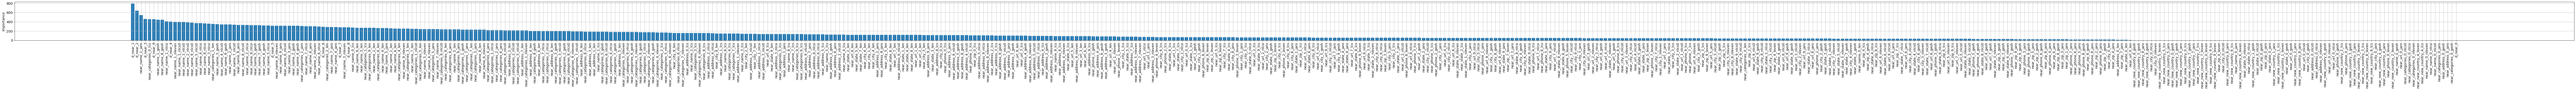

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

train = postprocess(train)
test = postprocess(test)
score, precision, recall = get_score(train)
print(f"CV: {score:.6f}")
print(score, precision, recall)

# Submit

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
ssub = ssub.merge(test[["id", "matches"]], on="id")
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()